# Structural equation model for shortcut dataset



In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
import IPython
import time

In [0]:
# Dataset specification
n = 1000
dim = 1
std = 10.0
# Train specification
epochs = 100
lr = 0.00001
bs = 100
log_interval = 10

In [0]:
# Setting up SEM
## Train set
x1_tr = torch.FloatTensor(n,1).normal_(mean=0,std=std)
y_tr = x1_tr + torch.FloatTensor(n,1).normal_(mean=0,std=std)
x2_tr = y_tr + torch.FloatTensor(n,1).normal_(mean=0,std=1)
x_tr = torch.cat((x1_tr,x2_tr),1)
## Test set (reversed spurious correlation)
x1_te = torch.FloatTensor(n,1).normal_(mean=0,std=std)
y_te = x1_te + torch.FloatTensor(n,1).normal_(mean=0,std=std)
x2_te = - y_te  + torch.FloatTensor(n,1).normal_(mean=0,std=1)
x_te = torch.cat((x1_te,x2_te),1)

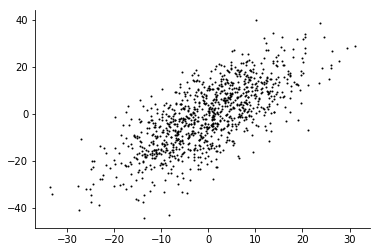

In [12]:
# Plot spurious correlations
ax = plt.subplot(111)
ax.scatter(x1_tr.numpy(),x2_tr.numpy(),color='black',s=1)
#ax.scatter(x1_te.numpy(),x2_te.numpy(),color='green',s=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

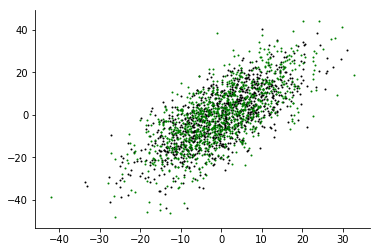

In [13]:
# Plot causal dependency
ax = plt.subplot(111)
ax.scatter(x1_tr.numpy(),y_tr.numpy(),color='black',s=1)
ax.scatter(x1_te.numpy(),y_te.numpy(),color='green',s=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [0]:
train_data = utils.TensorDataset(x_tr,y_tr) 
train_loader = utils.DataLoader(train_data,batch_size=bs) 
test_data = utils.TensorDataset(x_te,y_te) 
test_loader = utils.DataLoader(test_data,batch_size=n) 

In [0]:
# Build FC net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dim*2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()     

In [8]:
out = display(IPython.display.Pretty('Starting'), display_id=True)
time.sleep(1)

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.view(-1, 2)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            out.update(IPython.display.Pretty('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                           bs * batch_idx / len(train_loader), loss.item())))
            
print('Train MSE: '+str(criterion(net_out,target).mean().item()))

for idx, (data, target) in enumerate(test_loader):
  data, target = Variable(data), Variable(target)
  data = data.view(-1, 2)
  optimizer.zero_grad()
  net_out = net(data)
  print('Test MSE: '+str(criterion(net_out,target).mean().item()))
  

Train Epoch: 100 [0/1000 (0%)]	Loss: 1.942249

Train MSE: 2.556887626647949
Test MSE: 741.9774780273438


Outcome is as expected, model only looks at spurious correlation if easier and fails on test set, if spurious correlation is low, model succeeds on test set.

To do: visualize stats to show model learns spurious correlations where it can, extend to "unfair Dsprites" dataset with convnet and use location and orientation in SEM setup.

In [9]:
# Load Dsprites
x = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
ims = x['imgs']
poses = x['latents_values']
ids = x['latents_classes']

FileNotFoundError: ignored

In [0]:
plt.imshow(ims[10,:,:],cmap='gray')

In [10]:
squares = []
squares_positions = []
hearts = []
hearts_positions = []

for i in range(len(poses)):
  if poses[i][1] == 1.0 and poses[i][2] >= 0.8 and poses[i][3] == 0:
      squares.append(ims[i,:,:])
      squares_positions.append((poses[i][4],poses[i][5]))
  elif poses[i][1] == 3.0 and poses[i][2] >= 0.8 and poses[i][3] == 0:
      hearts.append(ims[i,:,:])
      hearts_positions.append((poses[i][4],poses[i][5]))
      
squares = np.array(squares)
squares_xy = squares_positions
hearts = np.array(hearts)
hearts_xy = hearts_positions

NameError: ignored

In [0]:
## Use different subset indices for hearts and squares unbiased
unbiased_data_idcs = np.arange(0,len(squares))
np.random.shuffle(unbiased_data_idcs)
unbiased_squares = unbiased_data_idcs[:(len(squares)//2)].copy()
np.random.shuffle(unbiased_data_idcs)
np.random.shuffle(unbiased_data_idcs)
unbiased_hearts = unbiased_data_idcs[:(len(squares)//2)]

biased_squares = []
biased_hearts = []

for i in range(len(squares)):
  if squares_xy[i][0] < 0.5 and squares_xy[i][1] < 0.5:
    biased_squares.append(i)
  elif squares_xy[i][0] > 0.5 and squares_xy[i][1] > 0.5:
    biased_squares.append(i)
  if hearts_xy[i][0] > 0.5 and hearts_xy[i][1] < 0.5:
    biased_hearts.append(i)
  elif hearts_xy[i][0] < 0.5 and hearts_xy[i][1] > 0.5:
    biased_hearts.append(i)
    
biased_squares = np.array(biased_squares)
np.random.shuffle(biased_squares)
biased_hearts = np.array(biased_hearts)
np.random.shuffle(biased_hearts)

In [12]:
from torchvision.utils import make_grid as make_grid

some_unbiased_squares = squares[unbiased_squares[:25]]
some_unbiased_hearts = hearts[unbiased_hearts[:25]]
some_biased_squares = squares[biased_squares[:25]]
some_biased_hearts = hearts[biased_hearts[:25]]


TypeError: ignored

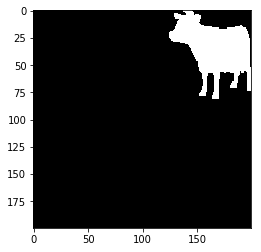

In [56]:
from PIL import Image
import requests
from io import BytesIO
import cv2
from resizeimage import resizeimage

response = requests.get("https://github.com/mmssouza/kimia99/raw/master/bunny04.png")
bunny = Image.open(BytesIO(response.content))
bunny = np.uint8(np.array(bunny))
bunny = bunny//255
bunny = np.abs(bunny-1)
bunny = np.pad(bunny,((54,54),(34,34)),mode='constant')
response = requests.get("https://github.com/mmssouza/kimia99/raw/master/cow1.png")
cow = Image.open(BytesIO(response.content))
#cow = resizeimage.resize_cover(cow, [92, 120], validate=False)
#cow = resizeimage.resize_contain(cow, [92,120], resample=Image.LANCZOS)
cow = np.uint8(np.array(cow))
cow = cv2.resize(cow, (90,100), interpolation = cv2.INTER_AREA)
cow = cow//255
cow = np.abs(cow-1)
cow = np.pad(cow,((47,47),(40,40)),mode='constant')

num_rows, num_cols = bunny.shape[:2]

# bottom right: 46 39 to 60 70
translation_matrix = np.float32([ [1,0,78], [0,1,-56] ])
img_translation = cv2.warpAffine(cow, translation_matrix, (num_cols, num_rows))
plt.imshow(img_translation,cmap='gray')

In [0]:
biased_train_bun = []
biased_train_cow = []

for i in range(1000):
  
  x_val = np.random.randint(46,60)
  y_val = np.random.randint(39,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  x_val = np.random.randint(-53,-39)
  y_val = np.random.randint(-65,-34)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  
  y_val = np.random.randint(44,64)
  x_val = np.random.randint(-46,-22)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  y_val = np.random.randint(-56,-33)
  x_val = np.random.randint(55,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  
unbiased_train_bun = []
unbiased_train_cow = []

for i in range(2000):
  
  x_val = np.random.randint(-53,60)
  y_val = np.random.randint(-65,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  unbiased_train_bun.append(im)
  
  y_val = np.random.randint(-56,64)
  x_val = np.random.randint(-46,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  unbiased_train_cow.append(im)
  
biased_train_cow = np.array(biased_train_cow)
biased_train_bun = np.array(biased_train_bun)
unbiased_train_cow = np.array(unbiased_train_cow)
unbiased_train_bun = np.array(unbiased_train_bun)

In [0]:
unbiased_squares = unbiased_train_cow
unbiased_hearts = unbiased_train_bun
biased_squares = biased_train_cow
biased_hearts = biased_train_bun

In [0]:
some_unbiased_squares = biased_squares[:25]
np.random.shuffle(some_unbiased_squares)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


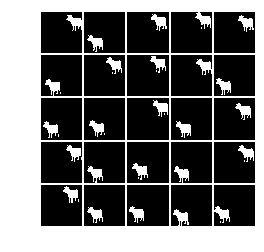

In [101]:
grid = make_grid(torch.from_numpy(np.float32(some_unbiased_squares)).view(25,1,200,200),nrow=5,pad_value=1,padding=10)
plt.axis('off')
plt.imsave('unbiased_squares',grid.numpy().transpose(1,2,0))
plt.imshow(grid.numpy().transpose(1,2,0))

In [0]:
unbiased_data = np.concatenate((unbiased_squares,unbiased_hearts))
unbiased_data = torch.from_numpy(np.float32(unbiased_data))
labels = np.concatenate((np.zeros(len(unbiased_squares)),np.ones(len(unbiased_squares))))
labels = torch.from_numpy(labels).long()
biased_data = np.concatenate((biased_squares,biased_hearts))
biased_data = torch.from_numpy(np.float32(biased_data))

train_data = utils.TensorDataset(biased_data,labels) 
train_loader = utils.DataLoader(train_data,batch_size=100,shuffle=True) 
test_data = utils.TensorDataset(unbiased_data,labels) 
test_loader = utils.DataLoader(test_data,batch_size=100) 

In [0]:
# Build FC net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(200*200, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 5, 2, padding=2)
        self.c2 = nn.Conv2d(32, 32, 5, 2, padding=2)
        self.c3 = nn.Conv2d(32, 32, 5, 2, padding=2)
        self.pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
      
      
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.c1 = nn.Conv2d(1, 128, 5)#, 2, padding=2)
        self.c2 = nn.Conv2d(128, 128, 5)#, 2, padding=2)
        self.c3 = nn.Conv2d(128, 128, 5)#, 2, padding=2)
        self.pool = nn.AvgPool2d(64)
        self.fc = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#criterion = nn.MSELoss()     
criterion = nn.CrossEntropyLoss()

In [87]:
out = display(IPython.display.Pretty('Starting'), display_id=True)
time.sleep(1)
import pdb

epochs = 5

for epoch in range(epochs):
    total = 0.
    correct = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.view(-1, 1, 200*200)
        target = target.squeeze()
        optimizer.zero_grad()
        net_out = net(data).squeeze()
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            out.update(IPython.display.Pretty('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                           bs * batch_idx / len(train_loader), loss.item())))
            
        _, predicted = torch.max(net_out.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Train Acc: '+str(correct/total))

total = 0.
correct = 0.
for idx, (data, target) in enumerate(test_loader):
  data, target = Variable(data), Variable(target)
  data = data.view(-1, 1,200*200)
  optimizer.zero_grad()
  net_out = net(data).squeeze()
  _, predicted = torch.max(net_out.data, 1)
  total += target.size(0)
  correct += (predicted == target).sum().item()
print('Test Acc: '+str(correct/total))

Train Epoch: 5 [3000/4000 (75%)]	Loss: 0.000000

Train Acc: 1.0
Test Acc: 0.492


tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1])


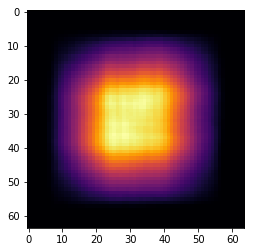

In [0]:
unbiased_hearts = squares[unbiased_hearts]
unbiased_hearts_means = np.mean(unbiased_hearts,axis=0)
plt.imshow(unbiased_hearts_means,cmap='inferno')

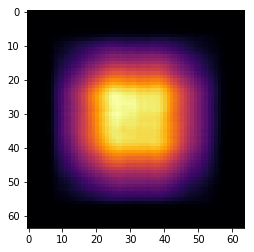

In [0]:

unbiased_squares = squares[unbiased_squares]
unbiased_squares_means = np.mean(unbiased_squares,axis=0)
plt.imshow(unbiased_squares_means,cmap='inferno')

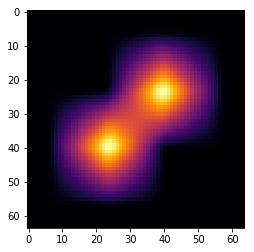

In [0]:

biased_hearts = squares[biased_hearts]
biased_hearts_means = np.mean(biased_hearts,axis=0)
plt.imshow(biased_hearts_means,cmap='inferno')


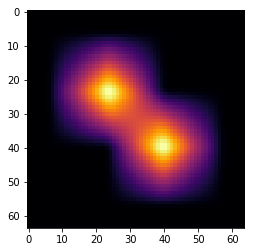

In [0]:

biased_squares = squares[biased_squares]
biased_squares_means = np.mean(biased_squares,axis=0)
plt.imshow(biased_squares_means,cmap='inferno')